# UBC Scientific Software Seminar

## January 20, 2017

1. Review: Simple machine learning problems and scikit-learn API
    * Regression
    * Classification
    * Clustering
    * Dimensionality reduction
2. Introduction to neural networks

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Review: Simple machine learning problems and scikit-learn API

The term ["machine learning"](https://en.wikipedia.org/wiki/Machine_learning) refers to the study and practice of using data to build models and make predictions. There are many kinds of data: text, images, videos, numerical measurements, etc. And there are many algorithms for building models from data. Our main reference is the [scikit-learn](http://scikit-learn.org) documentation but there are many, many more...

### Regression

[Linear regression](https://en.wikipedia.org/wiki/Linear_regression) is the simplest algorithm. Let's make some fake 1-dimensional data and recall how the scikit-learn API works.

In [3]:
# Create a column vector (as a 2D Numpy array) of 500 numbers sampled uniformly from [0,10]
N = 500
X = 10*np.random.rand(N,1)

In [4]:
# Choose parameters 2 and 3 as the slope and intercept of our fake data and some noise sampled from the normal distribution
y = 2*X + 3 + 2*np.random.randn(N,1)

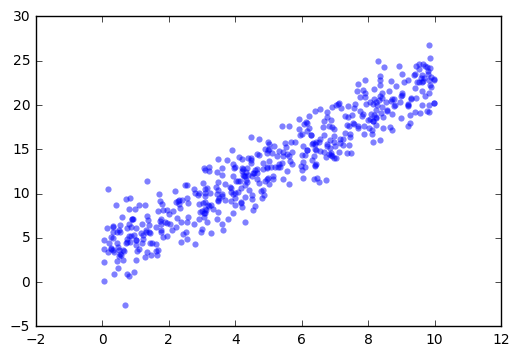

In [5]:
# Plot the random data
plt.scatter(X,y,lw=0,alpha=0.5);

Import the `LinearRegresssoin` class from the `linear_model` subpackage of `sklearn`.

In [6]:
from sklearn.linear_model import LinearRegression as LR

In [7]:
# Instantiate the model (an object from the LinearRegression class)
reg = LR()

In [8]:
# Fit the model to the data
reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

The model `reg` has computed the slope and intercept that best fits the data (relative to the sum of squared errors).

In [9]:
reg.coef_

array([[ 1.96086511]])

In [10]:
reg.intercept_

array([ 3.24568003])

In [11]:
# Plot a line using the linear model
X_test = np.linspace(-1,11,1000).reshape(1000,1)
y_test = reg.predict(X_test)

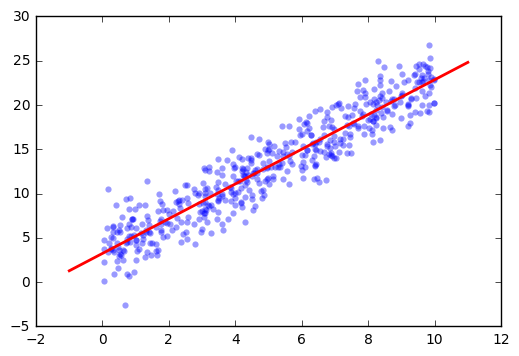

In [12]:
plt.scatter(X,y,lw=0,alpha=0.4); plt.hold('on');
plt.plot(X_test,y_test,'r',lw=2);

In [13]:
reg.score(X,y)

0.88568878354148883

### Clustering

[Clustering](https://en.wikipedia.org/wiki/Cluster_analysis) algorithms try to find naturally occuring groups within a dataset. The most straightforward algorithm is the [$k$-means clustering algorithm](https://en.wikipedia.org/wiki/K-means_clustering). Let's use $k$-means clustering to look at all the colors appearing in an image and find a small number of colors which best represent the entire set of colors.

In [14]:
from sklearn.datasets import load_sample_image

In [15]:
img = load_sample_image('flower.jpg')

In [16]:
type(img)

numpy.ndarray

In [17]:
h,w,d = img.shape
print(h,w,d)

427 640 3


The image is loaded as a 3D NumPy array: a 2D array of pixels where each pixel is a 3D vector describing a color (an RGB triple).

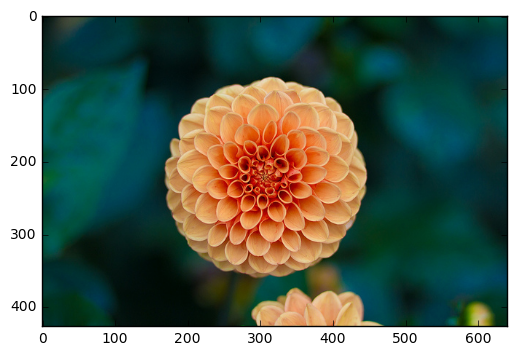

In [18]:
plt.imshow(img)

For example, the pixel situated 200 pixels from the top and 300 pixels from the left is:

In [19]:
img[200,300,:]

array([104,   0,  13], dtype=uint8)

That is Red 2, Green 0 and Blue 13 (on a scale of 0 to 255).

The datatype of the image array is `uint8` and we need to convert this to NumPy floats (scaled to [0,1]).

In [20]:
img_as_floats = np.array(img,dtype=np.float64)/255

We want to consider the collection of colors in the image as our dataset and so we reshape the array into a 2D array where each row is a color (sample) and the features in the sample is the RGB triple (scaled to [0,1]).

In [21]:
color_data = img_as_floats.reshape(h*w,d)

The first 5 colors appearing in the top left corner of the image are:

In [22]:
color_data[:5,:]

array([[ 0.00784314,  0.0745098 ,  0.05098039],
       [ 0.01176471,  0.07058824,  0.05098039],
       [ 0.02745098,  0.07843137,  0.05098039],
       [ 0.03137255,  0.08235294,  0.05490196],
       [ 0.02352941,  0.08235294,  0.05490196]])

The colors are points in 3-dimensional space and we are going to use the [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) algorithm to find clusters of colors.

In [23]:
from sklearn.cluster import KMeans

In [24]:
# Instantiate the model and set the number of clsuters to 64
clf = KMeans(n_clusters=64)

Our set of colors is quite large:

In [25]:
# Number of pixels in the image
h*w

273280

Let's take a random sample of colors instead to make the KMeans computation easier.

In [26]:
from sklearn.utils import shuffle

In [27]:
random_colors = shuffle(color_data)[:2000]

In [29]:
clf.fit(random_colors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=64, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Now we can replace every color in the image with the nearest cluster center.

In [42]:
kmeans_colors = clf.predict(color_data)

However, our colors are now assigned the index of the cluster center.

In [43]:
kmeans_colors[:5]

array([6, 6, 6, 6, 6], dtype=int32)

And so we need to translate this back to a triple of red, green and blue. First, we gather the cluster centres:

In [44]:
colors = clf.cluster_centers_

In [45]:
colors[:5]

array([[ 0.13088235,  0.22009804,  0.12401961],
       [ 0.84909804,  0.54415686,  0.29929412],
       [ 0.00754148,  0.19683258,  0.20388386],
       [ 0.00130719,  0.36825397,  0.36676004],
       [ 0.81691176,  0.27622549,  0.01004902]])

And now we translate the colors in `kmeans_colors` into their RGB triple:

In [46]:
new_image = np.array([colors[kmeans_colors[i]] for i in range(0,len(kmeans_colors))]).reshape(h,w,d)

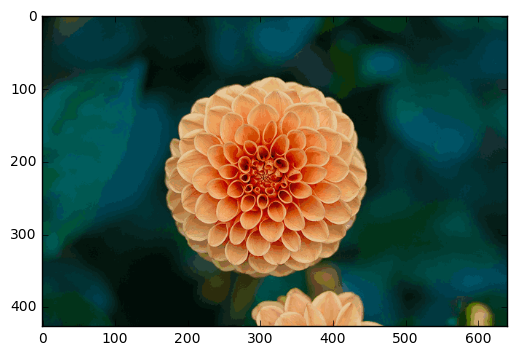

In [47]:
plt.imshow(new_image)

The image looks nearly the same after we have reduced the number of distinct colors to 64 by using the 64 clusters of colors found by KMeans!

### Dimensionality Reduction

Let's look more closely at the collection of colors in the flower image. Each color is a vector in 3D and we will use principal component analysis to project the 3-dimensional red-green-blue space to 2D.

In [48]:
from sklearn.decomposition import PCA

In [58]:
# Instantiate the model
pca = PCA(n_components=2)

In [59]:
# Find the 2D plane in the data which best captures the variation in the colors
pca.fit(color_data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [60]:
# Project all the colors in the image to 2D
colors_2D = pca.transform(color_data)

In [61]:
# Project all the cluster centers to 2D
clusters_2D = pca.transform(clf.cluster_centers_)

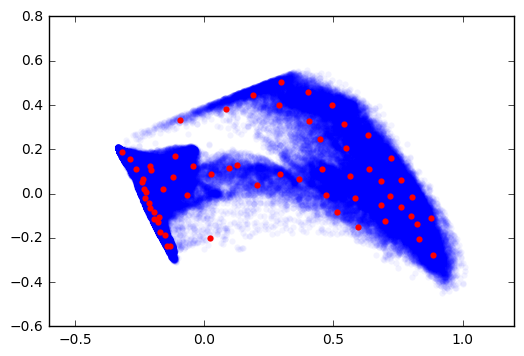

In [63]:
plt.scatter(colors_2D[:,0],colors_2D[:,1],alpha=0.05,lw=0);
plt.scatter(clusters_2D[:,0],clusters_2D[:,1],c='red',lw=0);

We can see the 64 cluster centers (red dots) found by KMeans capture the variation in the colors that appear in the image.

## 2. Introduction to neural networks

A neural network is another kind of algorithm to build a model based on data so that we can make predictions on new data. As a first example, a *multi-layered perceptron* (or *feedforward neural network*) is simply a function of the form:

$$
F(\mathbf{x}; W,b) = (F_L \circ \cdots \circ F_1)(\mathbf{x})
$$

where each layer $F_{\ell}$ is of the form

$$
F_{\ell}(\mathbf{a}^{\ell}; W^{\ell},b^{\ell}) = \sigma(W^{\ell} \mathbf{a}^{\ell} + b^{\ell})
$$

such that:

* $\sigma$ is the (vectorized) sigmoid function $\sigma(z) = \frac{1}{1 + e^{-z}}$
* $W^{\ell}$ is the weight matrix (at layer $\ell$) of size $n_{\ell + 1}$ by $n_{\ell}$
* $b^{\ell}$ is the bias vectors (at layer $\ell$) of size $n_{\ell + 1}$
* $\mathbf{a}^{\ell}$ is the vector of input activations at layer $\ell$ of size $n_{\ell}$

The function $F$ is a composition of affine transformations (composed with a sigmoid function).

**GOAL:** Given a training set $\{ \mathbf{x}_i \}_i$ of $N$ samples with corresponding output labels $\{ \mathbf{y}_i \}$, we would like to optimize the network parameters $W$ (weights) and $b$ (biases) relative to a cost function such as the squared error:

$$
C = \frac{1}{N} \sum_{i = 1}^N || \mathbf{y}_i - F(\mathbf{x}_i; W,b)||^2
$$

**IDEA:** Chose some initial guess for the weights and biases and use gradient descent to find optimal values relative to the cost function.

**CHALLENGES:** If the sample space is large (like a high resolution JPEG image), and if the number of samples $N$ is large, and if the number of layers $L$ is large, and if the size of each layer $n_{\ell}$ is large... then this is a hard computational problem!

**STRATEGY:** Stochastic gradient descent and backpropagation!